# Análise de Atrasos em Voos Domésticos no Brasil

Este notebook tem como objetivo analisar os dados de atrasos em voos domésticos no Brasil, utilizando dados públicos da Agência Nacional de Aviação Civil (ANAC). A análise buscará identificar os principais fatores que contribuem para os atrasos, com o intuito de fornecer insights para passageiros e companhias aéreas.

## 1. Preparação do Ambiente e Carregamento dos Dados

Nesta seção, vamos importar as bibliotecas necessárias e carregar os dados baixados da ANAC. Os dados referem-se aos percentuais de atrasos e cancelamentos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Added
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler # StandardScaler added
from sklearn.decomposition import PCA # Added
from sklearn.cluster import KMeans # Added

# Configurações para melhor visualização dos gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 7)

Vamos carregar o arquivo `Anexo I.csv`. A análise anterior mostrou que a primeira linha do arquivo não é o cabeçalho. Vamos pular a primeira linha e usar a segunda como cabeçalho.

In [2]:
path_anexo_i = "/home/ubuntu/projeto_atrasos_voos/Anexo I.csv"

try:
    # Pular a primeira linha (índice 0) e usar a segunda linha (índice 1) como cabeçalho
    df_anexo_i = pd.read_csv(path_anexo_i, sep=";", encoding="latin1", skiprows=1, low_memory=False)
    print("Anexo I carregado com sucesso, pulando a primeira linha!")
except Exception as e:
    print(f"Erro ao carregar Anexo I: {e}")
    try:
        df_anexo_i = pd.read_csv(path_anexo_i, sep=";", encoding="iso-8859-1", skiprows=1, low_memory=False)
        print("Anexo I carregado com sucesso usando ISO-8859-1, pulando a primeira linha!")
    except Exception as e2:
        print(f"Erro ao carregar Anexo I com ISO-8859-1: {e2}")
        df_anexo_i = None

if df_anexo_i is not None:
    print("Primeiras 5 linhas do Anexo I:")
    print(df_anexo_i.head())
    print("Colunas do DataFrame Anexo I:")
    # Imprimir as colunas para verificar os nomes exatos
    print(list(df_anexo_i.columns))
    print("Informações do DataFrame Anexo I:")
    df_anexo_i.info()
    print("Estatísticas descritivas do Anexo I (antes da conversão):")
    print(df_anexo_i.describe(include="all"))

Anexo I carregado com sucesso, pulando a primeira linha!
Primeiras 5 linhas do Anexo I:
                   Empresa_Aerea N_Voo Aeroporto_Origem_Designador_OACI  \
0  AAL - AMERICAN AIRLINES, INC.  0963                             KDFW   
1  AAL - AMERICAN AIRLINES, INC.  0937                             KDFW   
2  AAL - AMERICAN AIRLINES, INC.  7845                             KJFK   
3  AAL - AMERICAN AIRLINES, INC.  0951                             KJFK   
4  AAL - AMERICAN AIRLINES, INC.  0973                             KJFK   

                      Aeroporto_Origem_Nome_UF_Pais   \
0  DALLAS-FORT WORTH INTERNATIONAL AIRPORT(ESTADO...   
1  DALLAS-FORT WORTH INTERNATIONAL AIRPORT(ESTADO...   
2  JOHN F. KENNEDY INTERNATIONAL AIRPORT(ESTADOS ...   
3  JOHN F. KENNEDY INTERNATIONAL AIRPORT(ESTADOS ...   
4  JOHN F. KENNEDY INTERNATIONAL AIRPORT(ESTADOS ...   

  Aeroporto_Destino_Designador_OACI  \
0                              SBGR   
1                              SBGL   
2      

## 2. Limpeza e Transformação dos Dados

As colunas de percentuais precisam ser convertidas para o tipo numérico para que possamos realizar cálculos e análises. Elas usam vírgula como separador decimal.
Também vamos renomear as colunas que possuem espaços no final para facilitar o acesso.

In [3]:
if df_anexo_i is not None:
    # Renomear colunas com espaços no final (se existirem e forem consistentes)
    # Com base na observação anterior, os nomes corretos podem ser:
    coluna_origem_nome_correto = "Aeroporto_Origem_Nome_UF_Pais "
    coluna_destino_nome_correto = "Aeroporto_Destino_Nome_UF_Pais" # Ajustado para não ter espaço no final, conforme output de df_anexo_i.columns

    # Verificar se as colunas com espaço existem antes de tentar renomear ou usar
    if coluna_origem_nome_correto not in df_anexo_i.columns and "Aeroporto_Origem_Nome_UF_Pais" in df_anexo_i.columns:
        coluna_origem_nome_correto = "Aeroporto_Origem_Nome_UF_Pais"
    if "Aeroporto_Destino_Nome_UF_Pais " in df_anexo_i.columns: # Checa se a coluna com espaço existe
        coluna_destino_nome_correto = "Aeroporto_Destino_Nome_UF_Pais "
    elif "Aeroporto_Destino_Nome_UF_Pais" in df_anexo_i.columns: # Se não, usa a sem espaço
        coluna_destino_nome_correto = "Aeroporto_Destino_Nome_UF_Pais"

    cols_to_convert = [
        "Percentuais_de_Cancelamentos", 
        "Percentuais_de_Atrasos_superiores_a_30_minutos", 
        "Percentuais_de_Atrasos_superiores_a_60_minutos"
    ]
    
    for col in cols_to_convert:
        if col in df_anexo_i.columns:
            df_anexo_i[col] = df_anexo_i[col].astype(str).str.replace(",", ".").astype(float)
            print(f"Coluna {col} convertida para float.")
        else:
            print(f"Coluna {col} não encontrada no DataFrame.")

    print("Informações do DataFrame Anexo I (após conversão):")
    df_anexo_i.info()
    print("Estatísticas descritivas do Anexo I (após conversão):")
    print(df_anexo_i[cols_to_convert].describe())
else:
    print("DataFrame Anexo I não foi carregado. Limpeza não pode ser realizada.")

Coluna Percentuais_de_Cancelamentos convertida para float.
Coluna Percentuais_de_Atrasos_superiores_a_30_minutos convertida para float.
Coluna Percentuais_de_Atrasos_superiores_a_60_minutos convertida para float.
Informações do DataFrame Anexo I (após conversão):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12638 entries, 0 to 12637
Data columns (total 10 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Empresa_Aerea                                   12638 non-null  object 
 1   N_Voo                                           12638 non-null  object 
 2   Aeroporto_Origem_Designador_OACI                12638 non-null  object 
 3   Aeroporto_Origem_Nome_UF_Pais                   12638 non-null  object 
 4   Aeroporto_Destino_Designador_OACI               12638 non-null  object 
 5   Aeroporto_Destino_Nome_UF_Pais                  12638 non-null  object 
 6   Etapas

## 3. Análise Exploratória dos Dados (EDA) e Identificação de Fatores de Atraso

Vamos analisar os dados para identificar os principais fatores que contribuem para os atrasos.

Contagem de valores ausentes por coluna no Anexo I (após limpeza):
Empresa_Aerea                                     0
N_Voo                                             0
Aeroporto_Origem_Designador_OACI                  0
Aeroporto_Origem_Nome_UF_Pais                     0
Aeroporto_Destino_Designador_OACI                 0
Aeroporto_Destino_Nome_UF_Pais                    0
Etapas_Previstas                                  0
Percentuais_de_Cancelamentos                      0
Percentuais_de_Atrasos_superiores_a_30_minutos    0
Percentuais_de_Atrasos_superiores_a_60_minutos    0
dtype: int64
--- Média de Atrasos e Cancelamentos por Empresa Aérea ---
                                              Percentuais_de_Cancelamentos  \
Empresa_Aerea                                                                
KAL - KOREAN AIR LINES CO. LTD.                                   2.447500   
ONE - OCEANAIR LINHAS AÃREAS S.A. (AVIANCA)                     11.110000   
CPA - CATHAY PACIFIC AIRWAYS 

/tmp/ipykernel_11351/1851398627.py:15: UserWarning: Glyph 137 (\x89) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 137 (\x89) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


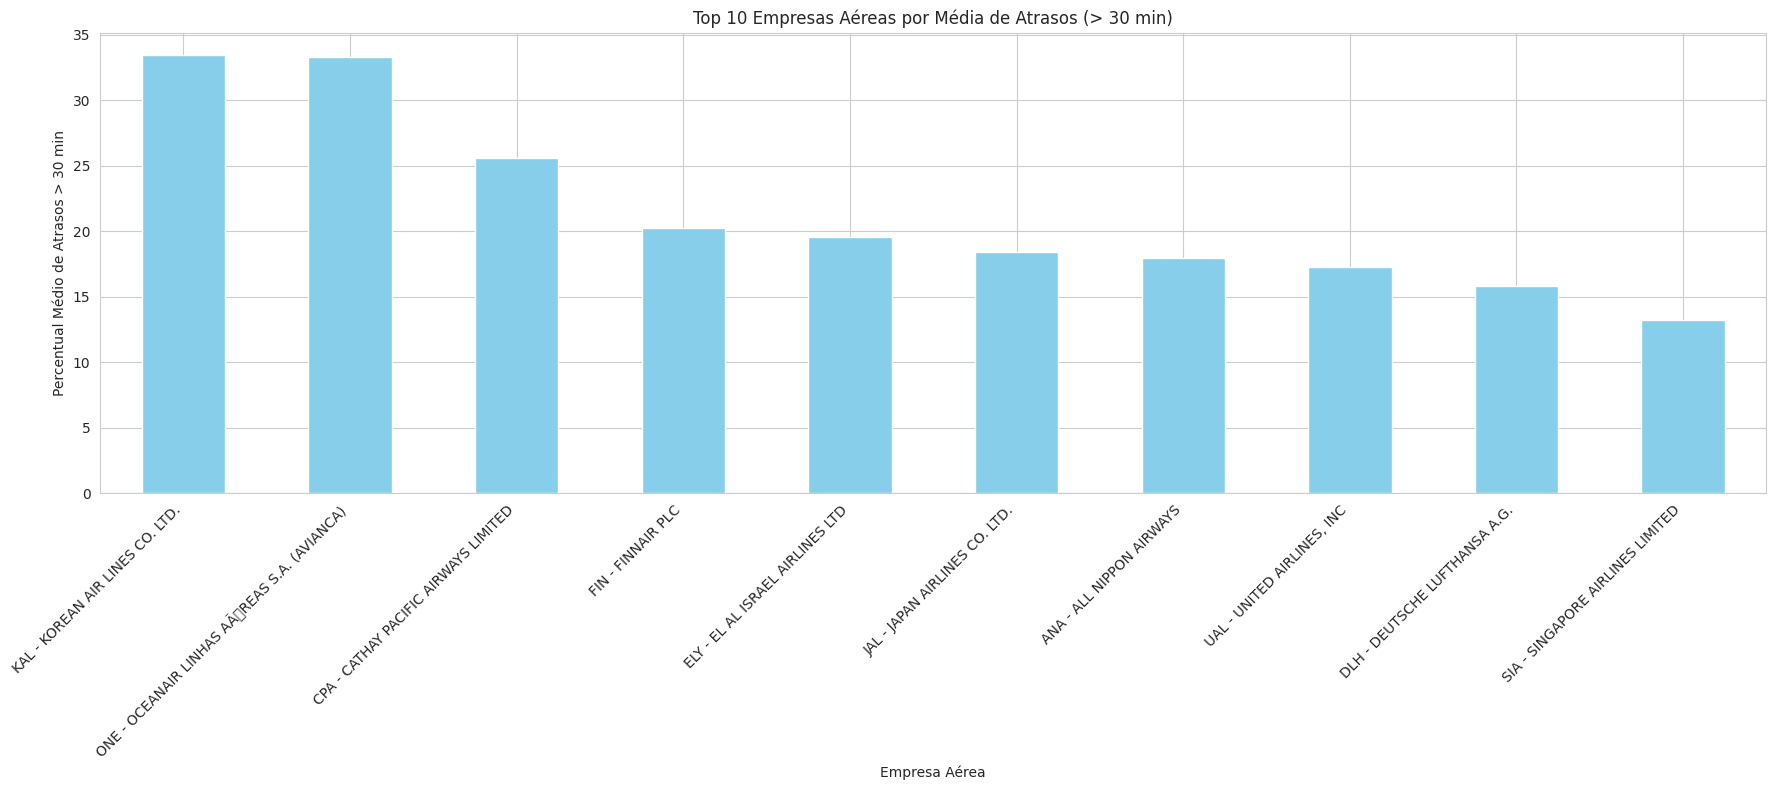

--- Média de Atrasos (>30 min) por Aeroporto de Origem (Top 10) ---
Aeroporto_Origem_Simples
LOGAN INTERNATIONAL AIRPORT                           42.223333
OÂ´HARE INTERNATIONAL AIRPORT                         30.106667
GEORGE BUSH INTERCONTINENTAL AIRPORT                  22.583333
PARACATU                                              22.220000
FORT LAUDERDALE-HOLLYWOOD INTERNATIONAL AIRPORT       21.570000
GOVERNOR FRANCISCO GABRIELLI INTERNATIONAL AIRPORT    21.382308
NEWARK LIBERTY INTERNATIONAL AIRPORT                  19.353333
PRESIDENTE JOÃO BATISTA FIGUEIREDO                   17.647059
MIAMI INTERNATIONAL AIRPORT                           17.006333
AEROPORTO ELIAS BREDER                                16.665000
Name: Percentuais_de_Atrasos_superiores_a_30_minutos, dtype: float64


/tmp/ipykernel_11351/1851398627.py:30: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


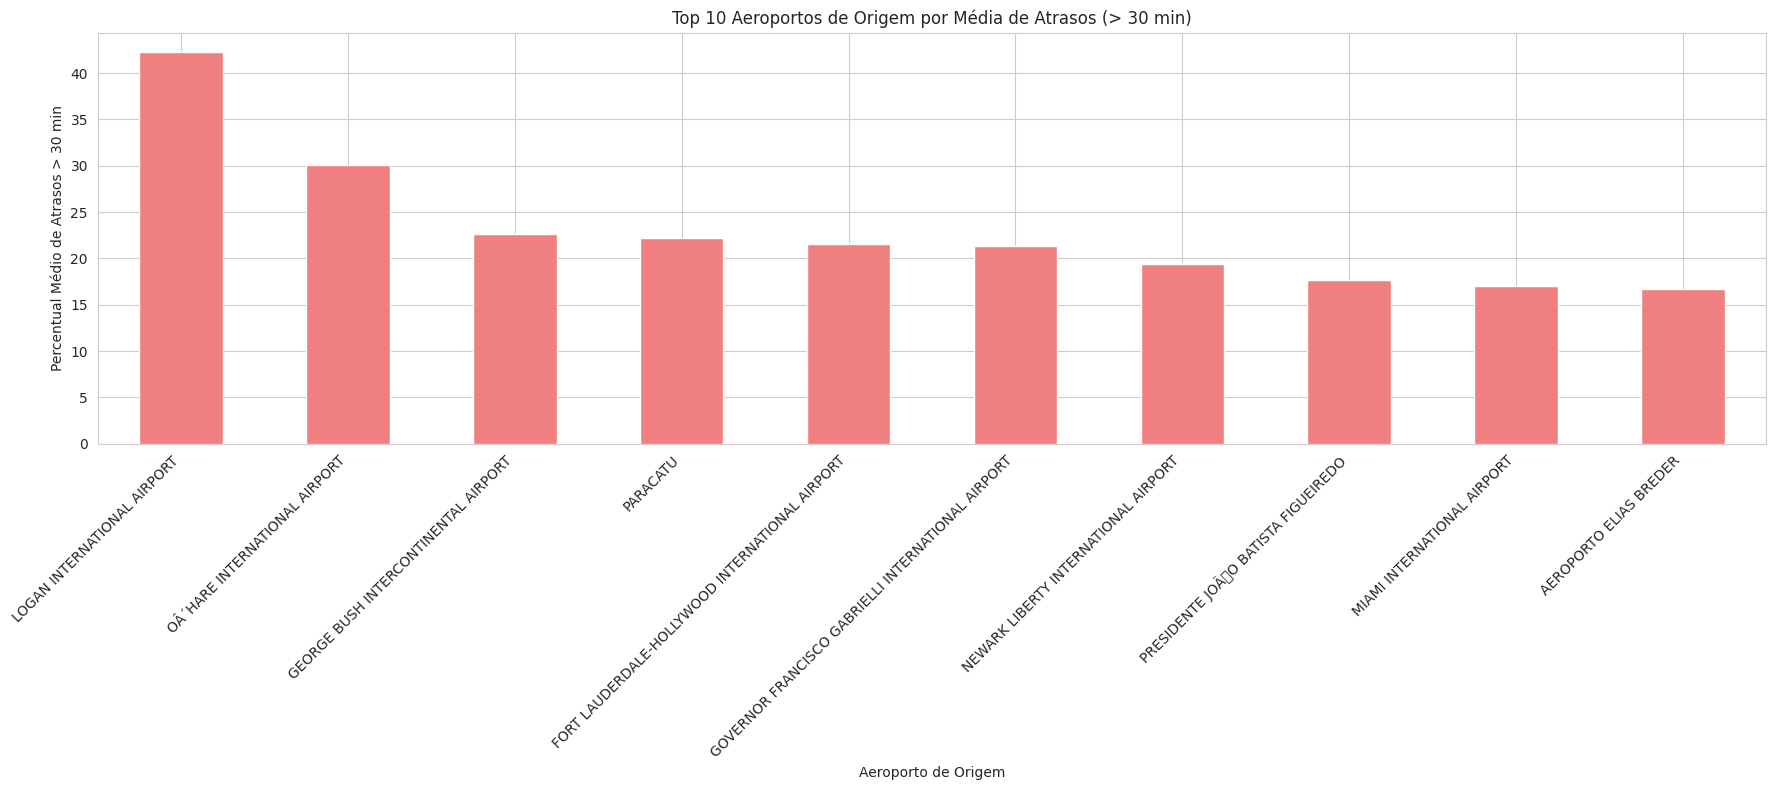

--- Média de Atrasos (>30 min) por Aeroporto de Destino (Top 10) ---
Aeroporto_Destino_Simples
DALLAS-FORT WORTH INTERNATIONAL AIRPORT    50.000000
LOGAN INTERNATIONAL AIRPORT                38.942500
OR TAMBO INTERNATIONAL AIRPORT             32.881250
LONDON HEATHROW AIRPORT                    32.142857
TENENTE LUND PRESETTO                      25.000000
MÃRIO DE ALMEIDA FRANCO                   24.138000
JOHN F. KENNEDY INTERNATIONAL AIRPORT      22.905000
FRANKFURT INTERNATIONAL AIRPORT            22.583571
PARACATU                                   22.220000
ORLANDO INTERNATIONAL AIRPORT              22.195000
Name: Percentuais_de_Atrasos_superiores_a_30_minutos, dtype: float64


/tmp/ipykernel_11351/1851398627.py:47: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


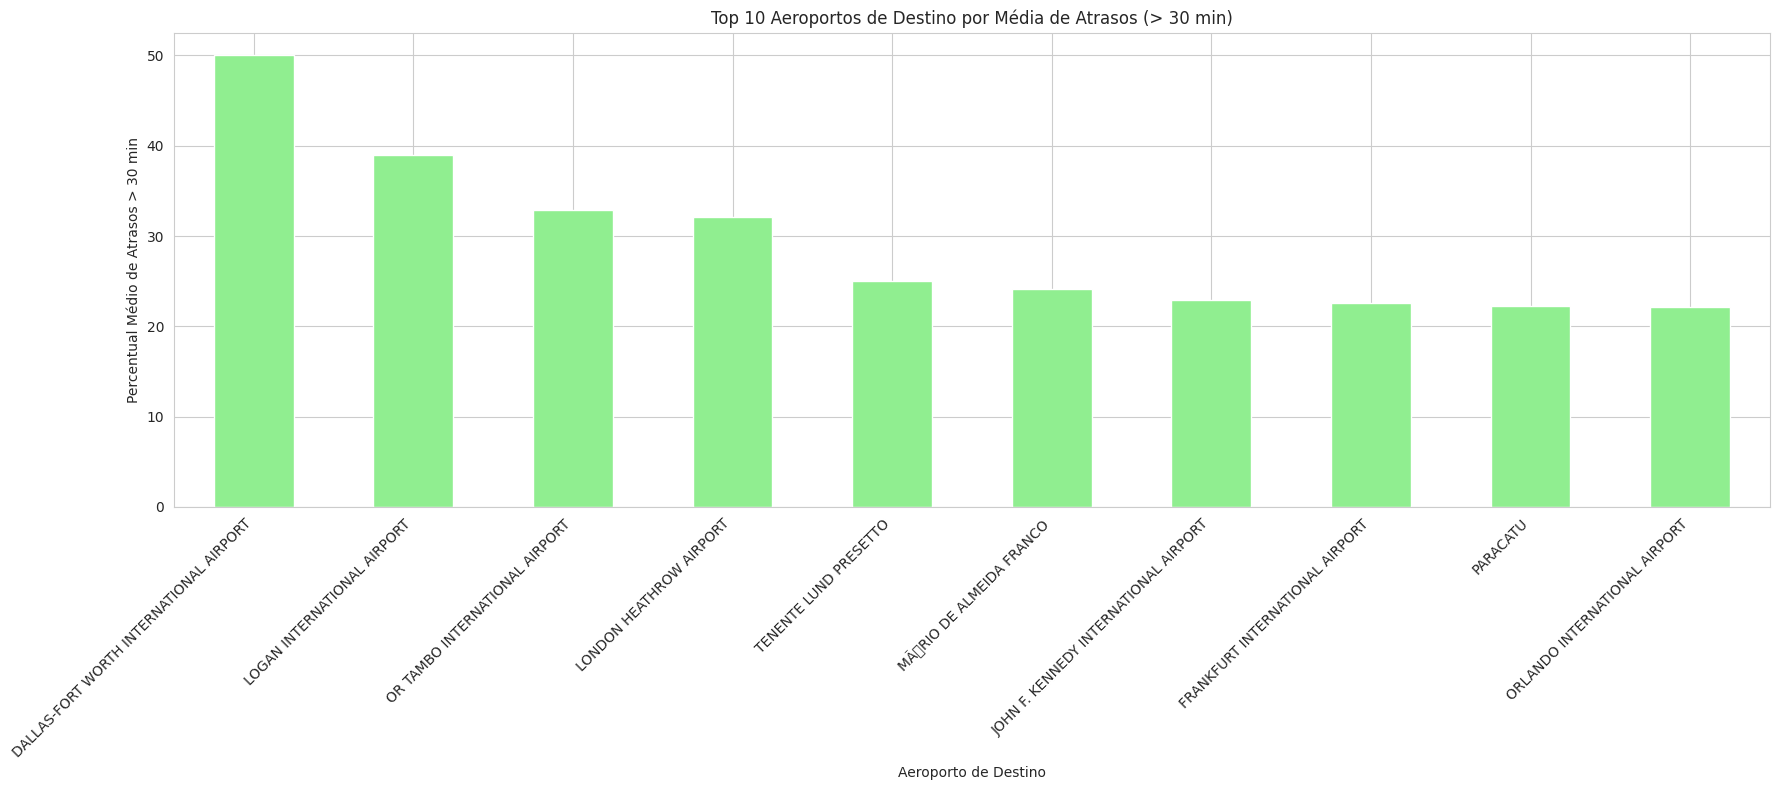

Análise de fatores de atraso concluída. Os gráficos mostram as empresas e aeroportos com maiores médias de atraso.


In [4]:
if df_anexo_i is not None:
    print("Contagem de valores ausentes por coluna no Anexo I (após limpeza):")
    print(df_anexo_i.isnull().sum().sort_values(ascending=False))
    
    media_por_empresa = df_anexo_i.groupby("Empresa_Aerea")[cols_to_convert].mean().sort_values(by="Percentuais_de_Atrasos_superiores_a_30_minutos", ascending=False)
    print("--- Média de Atrasos e Cancelamentos por Empresa Aérea ---")
    print(media_por_empresa.head(10))
    
    plt.figure(figsize=(18, 8))
    media_por_empresa["Percentuais_de_Atrasos_superiores_a_30_minutos"].head(10).plot(kind="bar", color="skyblue")
    plt.title("Top 10 Empresas Aéreas por Média de Atrasos (> 30 min)")
    plt.ylabel("Percentual Médio de Atrasos > 30 min")
    plt.xlabel("Empresa Aérea")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    if coluna_origem_nome_correto in df_anexo_i.columns:
        df_anexo_i["Aeroporto_Origem_Simples"] = df_anexo_i[coluna_origem_nome_correto].str.split("(").str[0].str.strip()
        media_por_origem = df_anexo_i.groupby("Aeroporto_Origem_Simples")["Percentuais_de_Atrasos_superiores_a_30_minutos"].mean().sort_values(ascending=False)
        print("--- Média de Atrasos (>30 min) por Aeroporto de Origem (Top 10) ---")
        print(media_por_origem.head(10))
        
        plt.figure(figsize=(18, 8))
        media_por_origem.head(10).plot(kind="bar", color="lightcoral")
        plt.title("Top 10 Aeroportos de Origem por Média de Atrasos (> 30 min)")
        plt.ylabel("Percentual Médio de Atrasos > 30 min")
        plt.xlabel("Aeroporto de Origem")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Coluna de nome de aeroporto de origem ({coluna_origem_nome_correto}) não encontrada para análise.")
    
    if coluna_destino_nome_correto in df_anexo_i.columns:
        df_anexo_i["Aeroporto_Destino_Simples"] = df_anexo_i[coluna_destino_nome_correto].str.split("(").str[0].str.strip()
        media_por_destino = df_anexo_i.groupby("Aeroporto_Destino_Simples")["Percentuais_de_Atrasos_superiores_a_30_minutos"].mean().sort_values(ascending=False)
        print("--- Média de Atrasos (>30 min) por Aeroporto de Destino (Top 10) ---")
        print(media_por_destino.head(10))

        plt.figure(figsize=(18, 8))
        media_por_destino.head(10).plot(kind="bar", color="lightgreen")
        plt.title("Top 10 Aeroportos de Destino por Média de Atrasos (> 30 min)")
        plt.ylabel("Percentual Médio de Atrasos > 30 min")
        plt.xlabel("Aeroporto de Destino")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Coluna de nome de aeroporto de destino ({coluna_destino_nome_correto}) não encontrada para análise.")
    
    print("Análise de fatores de atraso concluída. Os gráficos mostram as empresas e aeroportos com maiores médias de atraso.")
else:
    print("DataFrame Anexo I não foi carregado. Análise de fatores de atraso não pode ser realizada.")

### 3.2 Visualizações Adicionais

Vamos explorar mais algumas visualizações para entender melhor as relações entre as variáveis numéricas e suas distribuições.

Gerando Matriz de Correlação...


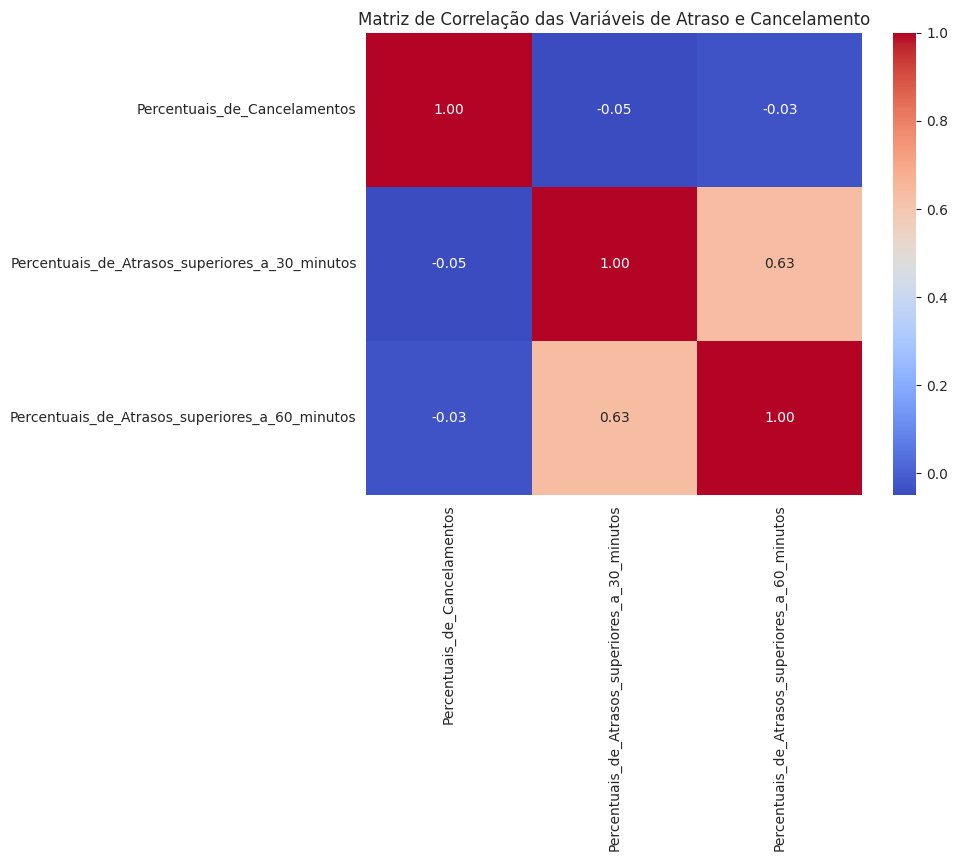

Matriz de Correlação:
                                                Percentuais_de_Cancelamentos  \
Percentuais_de_Cancelamentos                                        1.000000   
Percentuais_de_Atrasos_superiores_a_30_minutos                     -0.048511   
Percentuais_de_Atrasos_superiores_a_60_minutos                     -0.031305   

                                                Percentuais_de_Atrasos_superiores_a_30_minutos  \
Percentuais_de_Cancelamentos                                                         -0.048511   
Percentuais_de_Atrasos_superiores_a_30_minutos                                        1.000000   
Percentuais_de_Atrasos_superiores_a_60_minutos                                        0.632720   

                                                Percentuais_de_Atrasos_superiores_a_60_minutos  
Percentuais_de_Cancelamentos                                                         -0.031305  
Percentuais_de_Atrasos_superiores_a_30_minutos                        

In [5]:
if 'df_anexo_i' in locals() and df_anexo_i is not None:
    cols_percentuais = [
        "Percentuais_de_Cancelamentos", 
        "Percentuais_de_Atrasos_superiores_a_30_minutos", 
        "Percentuais_de_Atrasos_superiores_a_60_minutos"
    ]
    numerical_cols_for_corr = [col for col in cols_percentuais if col in df_anexo_i.columns and pd.api.types.is_numeric_dtype(df_anexo_i[col])]
    if numerical_cols_for_corr:
        print("Gerando Matriz de Correlação...")
        correlation_matrix = df_anexo_i[numerical_cols_for_corr].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Matriz de Correlação das Variáveis de Atraso e Cancelamento')
        plt.show()
        print("Matriz de Correlação:")
        print(correlation_matrix)
    else:
        print("Nenhuma coluna numérica de percentual encontrada para a matriz de correlação.")
else:
    print("DataFrame Anexo I não foi carregado. Visualizações adicionais não podem ser geradas.")

Gerando Gráficos de Distribuição...


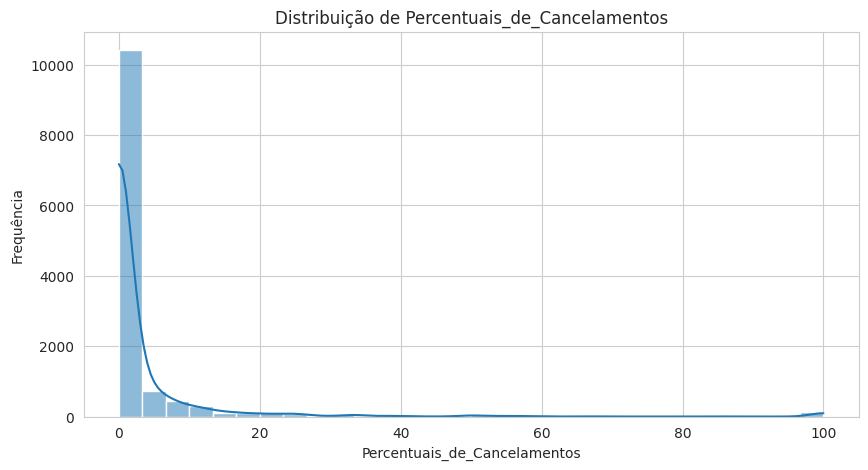

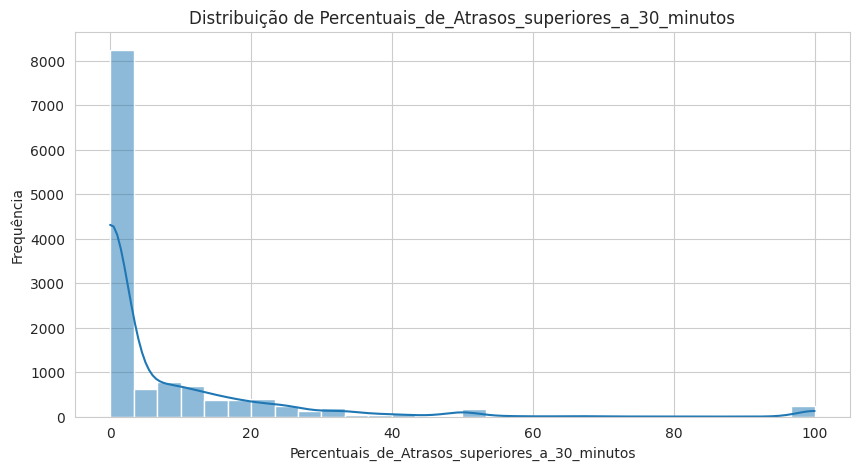

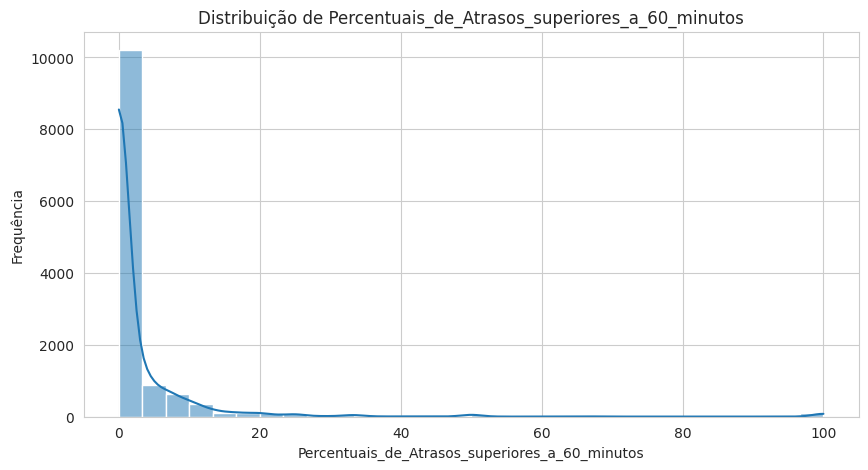

In [6]:
if 'df_anexo_i' in locals() and df_anexo_i is not None:
    cols_to_plot_dist = [
        "Percentuais_de_Cancelamentos", 
        "Percentuais_de_Atrasos_superiores_a_30_minutos", 
        "Percentuais_de_Atrasos_superiores_a_60_minutos"
    ]
    print("Gerando Gráficos de Distribuição...")
    for col in cols_to_plot_dist:
        if col in df_anexo_i.columns and pd.api.types.is_numeric_dtype(df_anexo_i[col]):
            plt.figure(figsize=(10, 5))
            sns.histplot(df_anexo_i[col], kde=True, bins=30)
            plt.title(f'Distribuição de {col}')
            plt.xlabel(col)
            plt.ylabel('Frequência')
            plt.show()
        else:
            print(f"Coluna {col} não encontrada ou não é numérica para plotar distribuição.")
else:
    print("DataFrame Anexo I não foi carregado. Distribuições não podem ser geradas.")

### 3.3 Análise de Componentes Principais (PCA) - Introdução

A Análise de Componentes Principais (PCA) é uma técnica de redução de dimensionalidade. PCA pode ser útil para transformar um grande conjunto de variáveis em um conjunto menor, preservando a maior parte da informação. No contexto de atrasos de voos, se tivéssemos muitas variáveis correlacionadas descrevendo diferentes aspectos dos voos ou condições operacionais, o PCA poderia ajudar a identificar os principais eixos de variação. Para este conjunto de dados agregados, sua aplicação direta pode ser limitada, mas exploraremos sua utilidade se mais features forem adicionadas ou para visualização de clusters em etapas futuras.


--- Iniciando Análise de Componentes Principais (PCA) ---
Features para PCA: ['Percentuais_de_Cancelamentos', 'Percentuais_de_Atrasos_superiores_a_30_minutos', 'Percentuais_de_Atrasos_superiores_a_60_minutos']
Dados padronizados para PCA.
Primeiras 5 linhas dos Componentes Principais:
        PC1       PC2
0 -0.499521 -0.317295
1 -0.568589  0.462835
2 -0.386255 -0.047566
3 -0.522567 -0.056983
4 -0.523281 -0.048924
Variância explicada por componente: [0.54590524 0.33174635]
Variância explicada acumulada: [0.54590524 0.8776516 ]


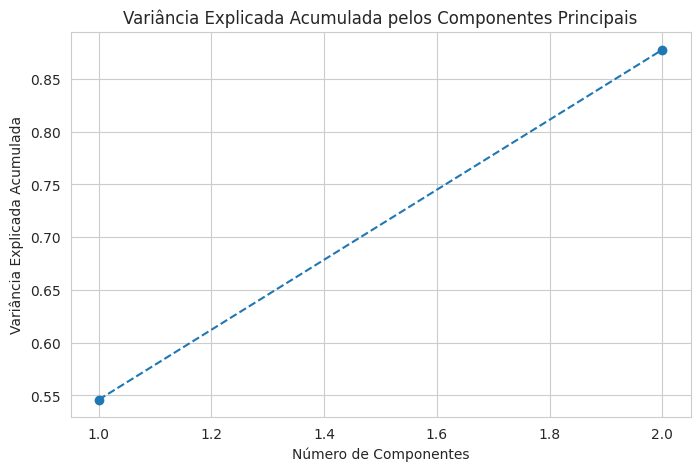

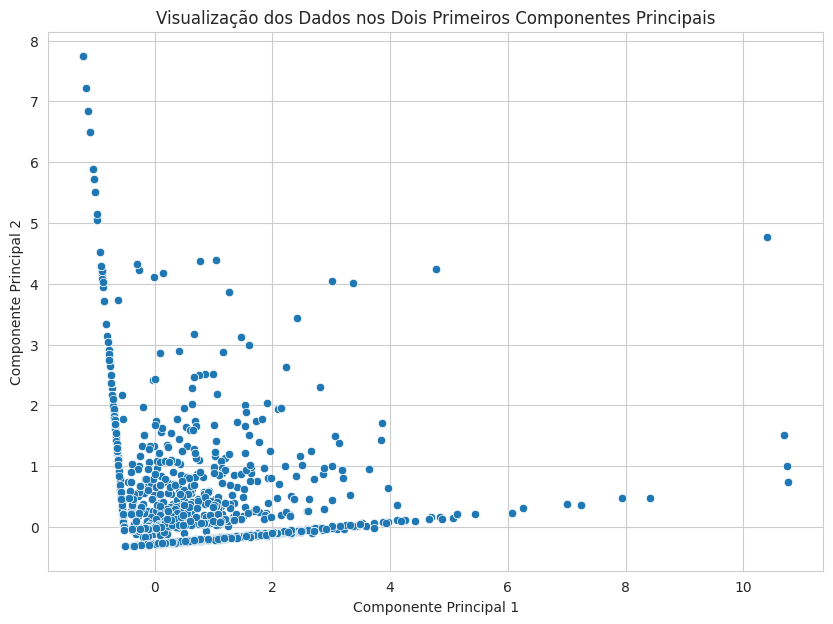

In [7]:
if 'df_anexo_i' in locals() and df_anexo_i is not None:
    print('\n--- Iniciando Análise de Componentes Principais (PCA) ---')
    pca_features = [
        'Percentuais_de_Cancelamentos', 
        'Percentuais_de_Atrasos_superiores_a_30_minutos', 
        'Percentuais_de_Atrasos_superiores_a_60_minutos'
    ]
    valid_pca_features = [col for col in pca_features if col in df_anexo_i.columns and pd.api.types.is_numeric_dtype(df_anexo_i[col])]
    if not valid_pca_features or len(valid_pca_features) < 2:
        print('Não há features numéricas suficientes ou válidas para PCA.')
    else:
        print(f'Features para PCA: {valid_pca_features}')
        df_pca_data = df_anexo_i[valid_pca_features].copy()
        for col in valid_pca_features:
            if df_pca_data[col].isnull().any():
                df_pca_data[col].fillna(df_pca_data[col].mean(), inplace=True)
                print(f'Valores NaN na coluna {col} preenchidos com a média.')
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df_pca_data) # Guardar para K-Means
        print('Dados padronizados para PCA.')
        pca = PCA(n_components=min(2, len(valid_pca_features)))
        principal_components = pca.fit_transform(scaled_data)
        pca_cols = [f'PC{i+1}' for i in range(principal_components.shape[1])]
        df_pca = pd.DataFrame(data=principal_components, columns=pca_cols)
        print('Primeiras 5 linhas dos Componentes Principais:')
        print(df_pca.head())
        print(f'Variância explicada por componente: {pca.explained_variance_ratio_}')
        print(f'Variância explicada acumulada: {pca.explained_variance_ratio_.cumsum()}')
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
        plt.title('Variância Explicada Acumulada pelos Componentes Principais')
        plt.xlabel('Número de Componentes')
        plt.ylabel('Variância Explicada Acumulada')
        plt.grid(True)
        plt.show()
        if principal_components.shape[1] >= 2:
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'])
            plt.title('Visualização dos Dados nos Dois Primeiros Componentes Principais')
            plt.xlabel('Componente Principal 1')
            plt.ylabel('Componente Principal 2')
            plt.grid(True)
            plt.show()
else:
    print('DataFrame Anexo I não foi carregado ou não está definido. PCA não pode ser realizado.')


### 3.4 Clusterização com K-Means - Introdução

K-Means é um algoritmo de clusterização que visa particionar as observações em 'k' clusters. Poderíamos usar K-Means para segmentar rotas aéreas ou empresas com base em seus perfis de pontualidade (percentuais de atrasos e cancelamentos), identificando grupos com características semelhantes. Isso pode revelar padrões de desempenho distintos que não são óbvios através de análises agregadas simples. Esta técnica será explorada em mais detalhes posteriormente.


--- Iniciando Clusterização com K-Means ---


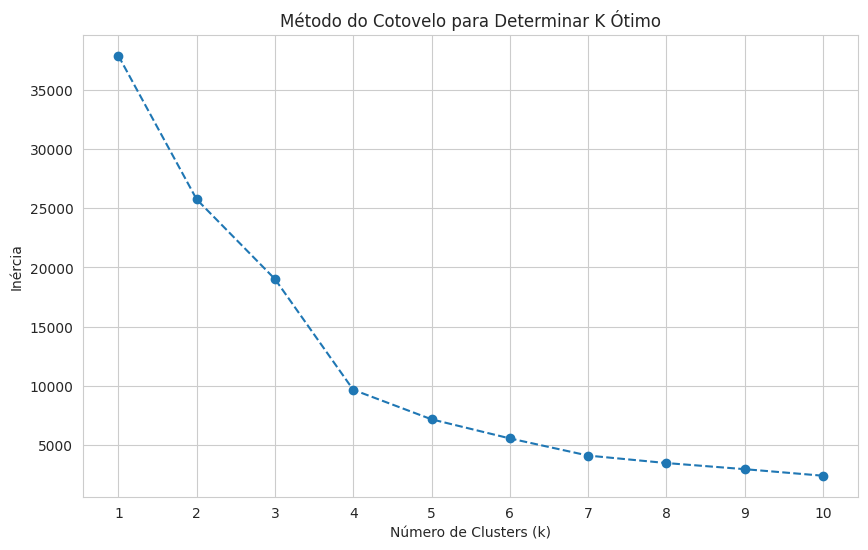

Aplicando K-Means com k=3
Contagem de observações por cluster:
Cluster_KMeans
0.0    11114
2.0     1421
1.0      103
Name: count, dtype: int64


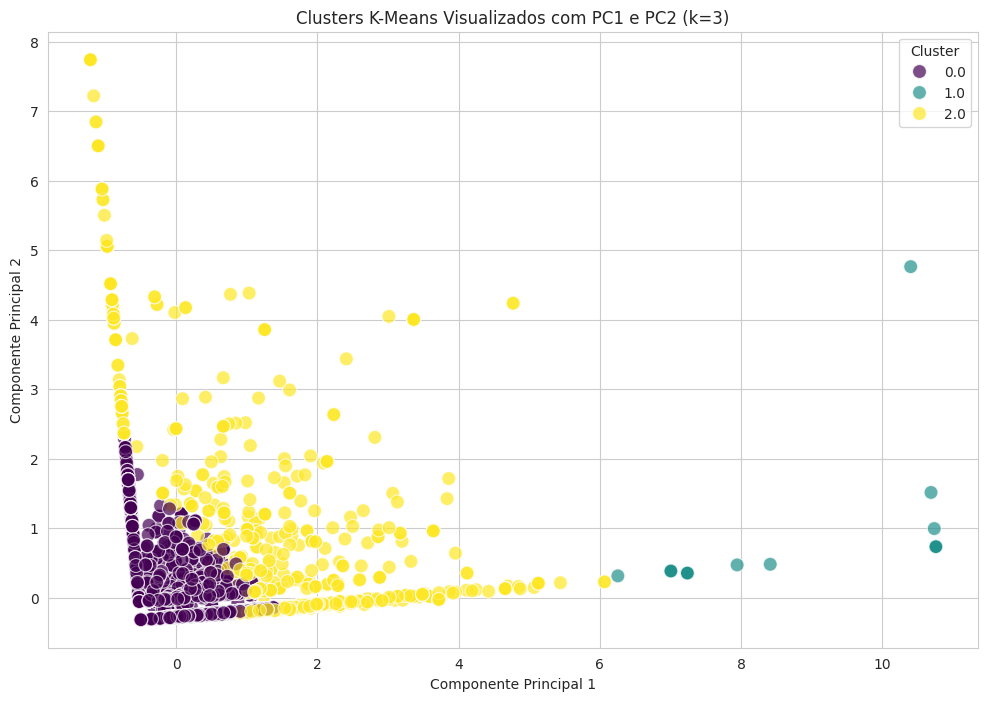

Características médias por cluster (usando features originais relevantes):
                Percentuais_de_Cancelamentos  \
Cluster_KMeans                                 
0.0                                 1.533166   
1.0                                 0.610777   
2.0                                18.126172   

                Percentuais_de_Atrasos_superiores_a_30_minutos  \
Cluster_KMeans                                                   
0.0                                                   3.500017   
1.0                                                  98.074563   
2.0                                                  33.631999   

                Percentuais_de_Atrasos_superiores_a_60_minutos  
Cluster_KMeans                                                  
0.0                                                   1.113210  
1.0                                                  93.382039  
2.0                                                   9.863174  


In [8]:
if 'df_anexo_i' in locals() and df_anexo_i is not None and 'scaled_data' in locals() and 'df_pca' in locals() and 'valid_pca_features' in locals():
    print('\n--- Iniciando Clusterização com K-Means ---')
    data_for_kmeans = scaled_data
    inertia = []
    k_range = range(1, 11)
    for k_val in k_range:
        kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
        kmeans.fit(data_for_kmeans)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.title('Método do Cotovelo para Determinar K Ótimo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    optimal_k = 3 # Ajustar este valor com base no gráfico do cotovelo
    print(f'Aplicando K-Means com k={optimal_k}')
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    cluster_labels = kmeans_final.fit_predict(data_for_kmeans)
    if 'df_pca_data' in locals():
        df_anexo_i.loc[df_pca_data.index, 'Cluster_KMeans'] = cluster_labels
        print('Contagem de observações por cluster:')
        print(df_anexo_i['Cluster_KMeans'].value_counts())
        if 'df_pca' in locals() and df_pca.shape[1] >= 2:
            plt.figure(figsize=(12, 8))
            sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_anexo_i.loc[df_pca_data.index, 'Cluster_KMeans'], palette='viridis', s=100, alpha=0.7)
            plt.title(f'Clusters K-Means Visualizados com PC1 e PC2 (k={optimal_k})')
            plt.xlabel('Componente Principal 1')
            plt.ylabel('Componente Principal 2')
            plt.legend(title='Cluster')
            plt.grid(True)
            plt.show()
        else:
            print('Não foi possível visualizar clusters com PCA (PC1 e PC2 não disponíveis ou df_pca não definido).')
        print('Características médias por cluster (usando features originais relevantes):')
        if valid_pca_features:
            print(df_anexo_i.groupby('Cluster_KMeans')[valid_pca_features].mean())
        else:
            print('Nenhuma feature válida para análise de cluster (valid_pca_features não definido).')
    else:
        print('df_pca_data não encontrado. Não é possível atribuir ou analisar clusters K-Means corretamente.')
else:
    print('Pré-requisitos para K-Means não atendidos (df_anexo_i, scaled_data, df_pca, ou valid_pca_features não definidos).')


## 4. Preparação dos Dados para Machine Learning

Para aplicar um modelo de machine learning, precisamos definir uma variável alvo (target) e selecionar as features (variáveis preditoras). Vamos criar uma variável binária que indica se um voo teve atraso significativo (por exemplo, mais de 10% de ocorrências de atrasos superiores a 30 minutos). Escolhemos 10% como um limiar arbitrário para este exemplo, idealmente este valor seria definido com base em conhecimento do negócio ou mais exploração.

In [9]:
if df_anexo_i is not None:
    # Criar variável alvo: 1 se Percentuais_de_Atrasos_superiores_a_30_minutos > 10, senão 0
    df_anexo_i["Atraso_Significativo"] = (df_anexo_i["Percentuais_de_Atrasos_superiores_a_30_minutos"] > 10).astype(int)
    
    print("Distribuição da variável alvo \"Atraso_Significativo\":")
    print(df_anexo_i["Atraso_Significativo"].value_counts(normalize=True))

    # Selecionar features categóricas para encoding
    # Para simplificar, vamos usar "Empresa_Aerea", "Aeroporto_Origem_Designador_OACI", "Aeroporto_Destino_Designador_OACI"
    # E "Etapas_Previstas" como numérica. Idealmente, mais features seriam exploradas e tratadas.
    features_categoricas = ["Empresa_Aerea", "Aeroporto_Origem_Designador_OACI", "Aeroporto_Destino_Designador_OACI"]
    features_numericas = ["Etapas_Previstas"]

    # Aplicar Label Encoding nas features categóricas
    # Nota: One-Hot Encoding seria mais robusto para modelos lineares, mas Label Encoding é mais simples para este exemplo.
    df_encoded = df_anexo_i.copy()
    for col in features_categoricas:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        else:
            print(f"Feature categórica {col} não encontrada para encoding.")
            # Remover da lista se não encontrada para evitar erro na seleção de X
            if col in features_categoricas: features_categoricas.remove(col)

    # Definir X (features) e y (target)
    X = df_encoded[features_categoricas + features_numericas].copy()
    y = df_encoded["Atraso_Significativo"].copy()

    # Tratar valores NaN que podem ter surgido (improvável com as features escolhidas, mas boa prática)
    X = X.fillna(X.mode().iloc[0]) # Preencher NaN com a moda (para categóricas) ou mediana/média (para numéricas)

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print("Preparação dos dados para ML concluída.")
else:
    print("DataFrame Anexo I não foi carregado. Preparação para ML não pode ser realizada.")

Distribuição da variável alvo "Atraso_Significativo":
Atraso_Significativo
0    0.772353
1    0.227647
Name: proportion, dtype: float64
Shape de X_train: (8846, 4)
Shape de X_test: (3792, 4)
Preparação dos dados para ML concluída.


## 5. Treinamento e Avaliação de Modelos Simples

Vamos treinar dois modelos simples: Regressão Logística e Árvore de Decisão.


--- Treinando Regressão Logística ---
Acurácia da Regressão Logística: 0.772415611814346
Relatório de Classificação da Regressão Logística:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      2929
           1       0.00      0.00      0.00       863

    accuracy                           0.77      3792
   macro avg       0.39      0.50      0.44      3792
weighted avg       0.60      0.77      0.67      3792

Matriz de Confusão da Regressão Logística:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


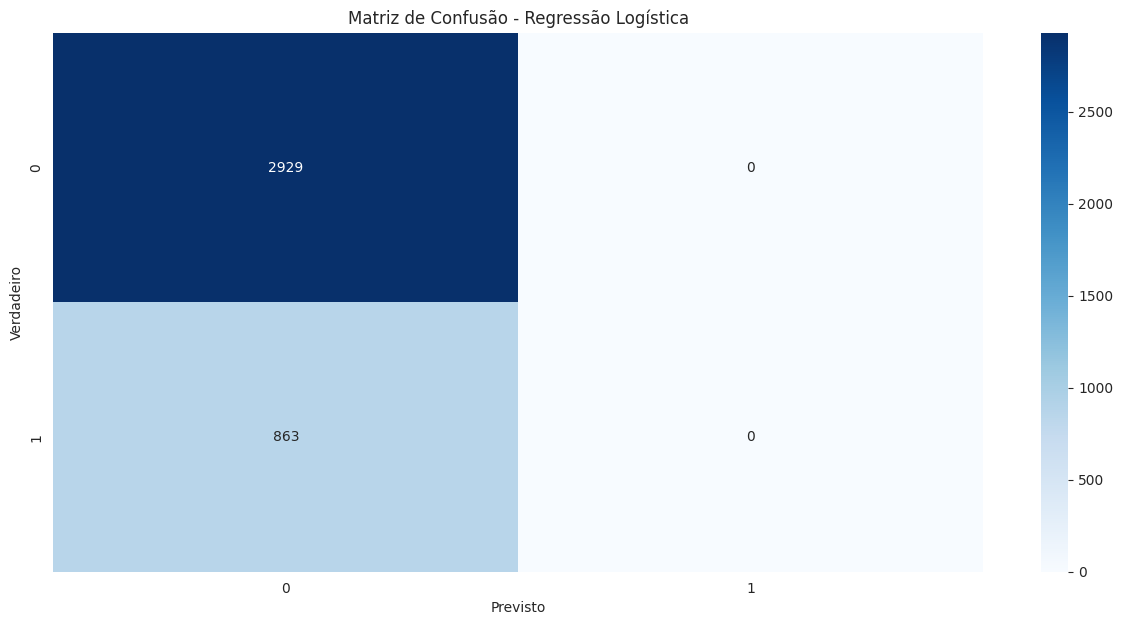


--- Treinando Árvore de Decisão ---
Acurácia da Árvore de Decisão: 0.7668776371308017
Relatório de Classificação da Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      2929
           1       0.45      0.12      0.19       863

    accuracy                           0.77      3792
   macro avg       0.62      0.54      0.53      3792
weighted avg       0.71      0.77      0.71      3792

Matriz de Confusão da Árvore de Decisão:


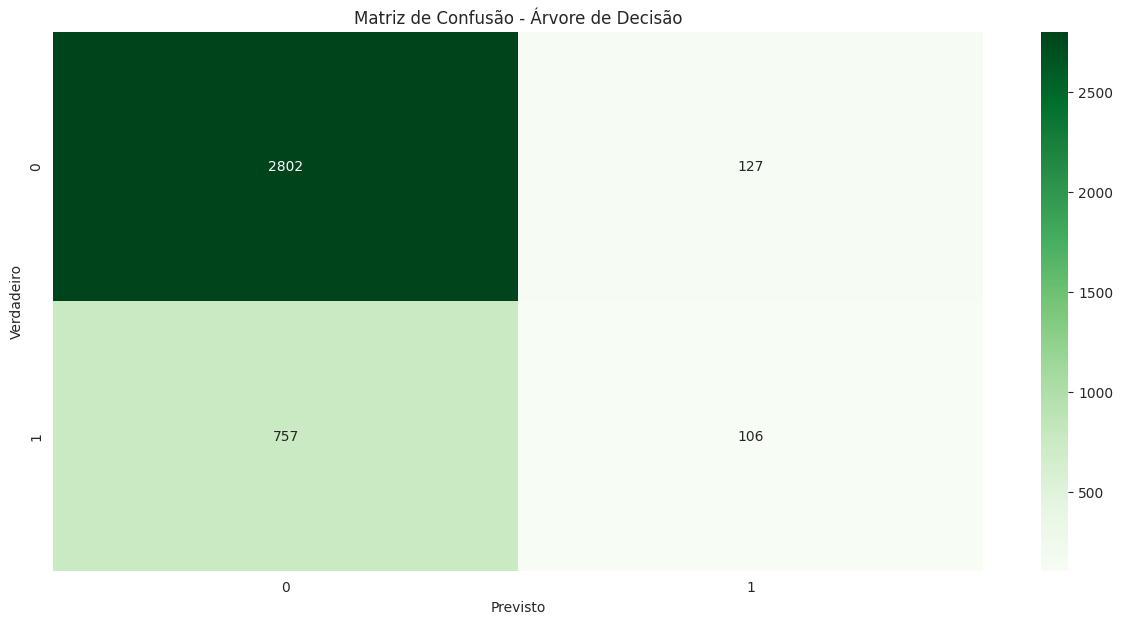

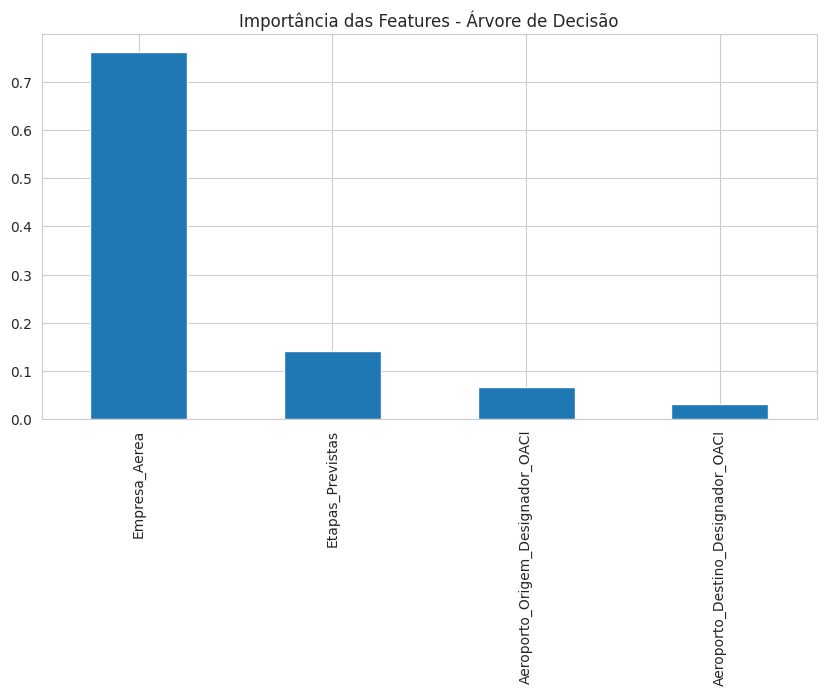

In [10]:
if "X_train" in locals(): # Verifica se X_train foi definido
    # Modelo 1: Regressão Logística
    print("") # Adiciona uma linha em branco antes do título
    print("--- Treinando Regressão Logística ---")
    log_reg = LogisticRegression(random_state=42, max_iter=1000, solver="liblinear") # liblinear é bom para datasets menores
    log_reg.fit(X_train, y_train)
    y_pred_log_reg = log_reg.predict(X_test)
    
    print("Acurácia da Regressão Logística:", accuracy_score(y_test, y_pred_log_reg))
    print("Relatório de Classificação da Regressão Logística:")
    print(classification_report(y_test, y_pred_log_reg))
    print("Matriz de Confusão da Regressão Logística:")
    sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão - Regressão Logística")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.show()
    # Modelo 2: Árvore de Decisão
    print("") # Adiciona uma linha em branco antes do título
    print("--- Treinando Árvore de Decisão ---")
    # Para simplicidade, não faremos poda ou otimização de hiperparâmetros extensiva
    tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5) # max_depth para evitar overfitting
    tree_clf.fit(X_train, y_train)
    y_pred_tree = tree_clf.predict(X_test)
    
    print("Acurácia da Árvore de Decisão:", accuracy_score(y_test, y_pred_tree))
    print("Relatório de Classificação da Árvore de Decisão:")
    print(classification_report(y_test, y_pred_tree))
    print("Matriz de Confusão da Árvore de Decisão:")
    sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt="d", cmap="Greens")
    plt.title("Matriz de Confusão - Árvore de Decisão")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.show()
    # Importância das features para Árvore de Decisão (se aplicável e desejado)
    if hasattr(tree_clf, "feature_importances_"):
        importances = pd.Series(tree_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        importances.plot(kind="bar")
        plt.title("Importância das Features - Árvore de Decisão")
        plt.show()
else:
    print("Dados de treino não foram preparados. Modelagem não pode ser realizada.")

### 5.2 Modelos de Ensemble (Random Forest e Gradient Boosting)

Modelos de ensemble combinam as previsões de múltiplos modelos base para melhorar a robustez e a precisão. Vamos treinar RandomForest e GradientBoosting para comparar com os modelos mais simples.


--- Treinando Random Forest ---


Acurácia do Random Forest: 0.7444620253164557
Relatório de Classificação do Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      2929
           1       0.46      0.74      0.57       863

    accuracy                           0.74      3792
   macro avg       0.68      0.74      0.69      3792
weighted avg       0.81      0.74      0.76      3792

Matriz de Confusão do Random Forest:


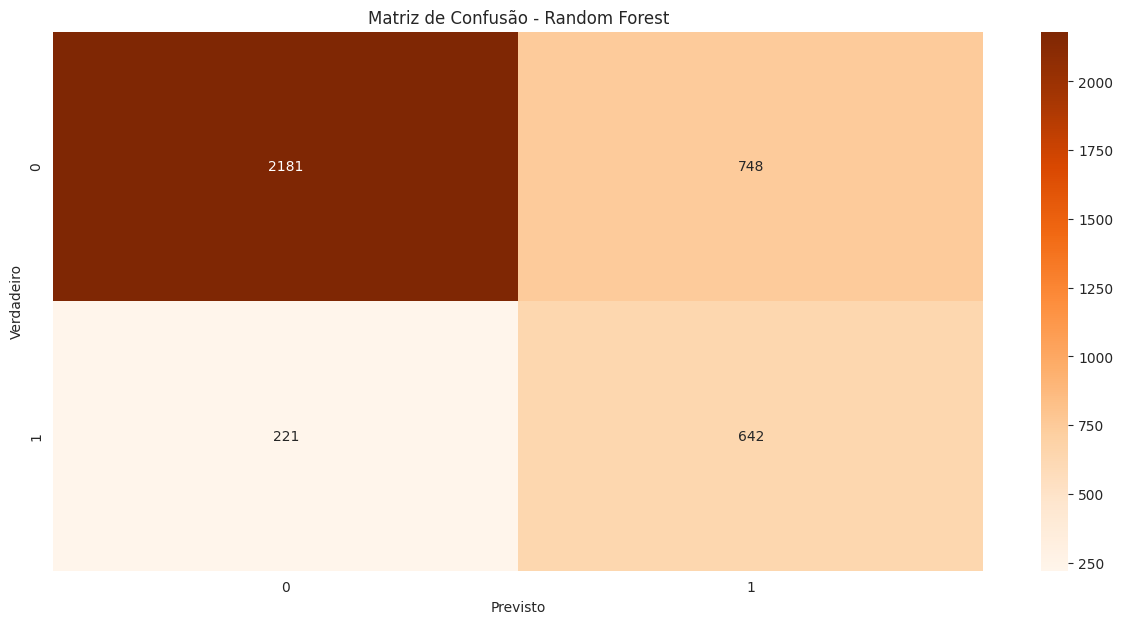

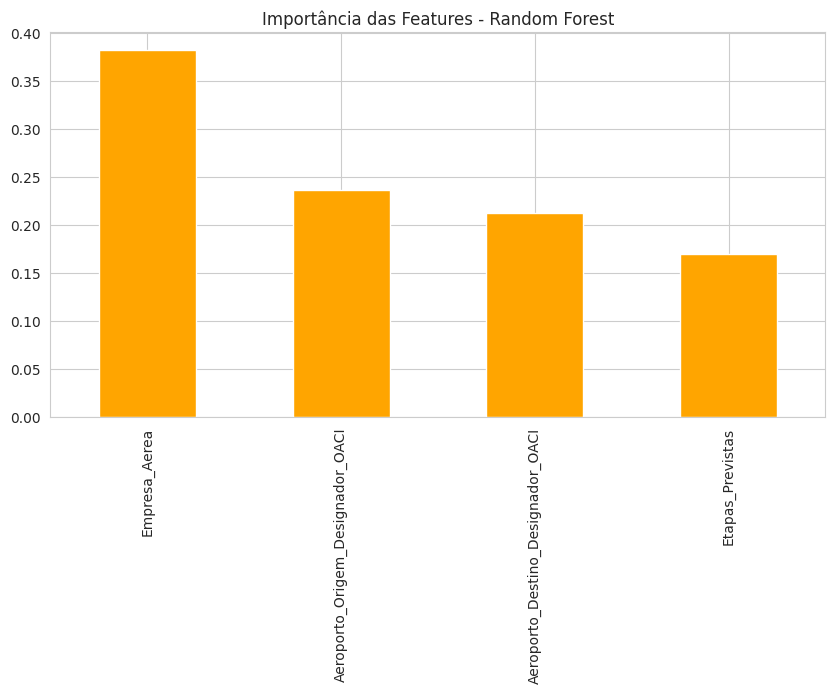


--- Treinando Gradient Boosting ---


Acurácia do Gradient Boosting: 0.7858649789029536
Relatório de Classificação do Gradient Boosting:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      2929
           1       0.64      0.14      0.23       863

    accuracy                           0.79      3792
   macro avg       0.71      0.56      0.55      3792
weighted avg       0.76      0.79      0.73      3792

Matriz de Confusão do Gradient Boosting:


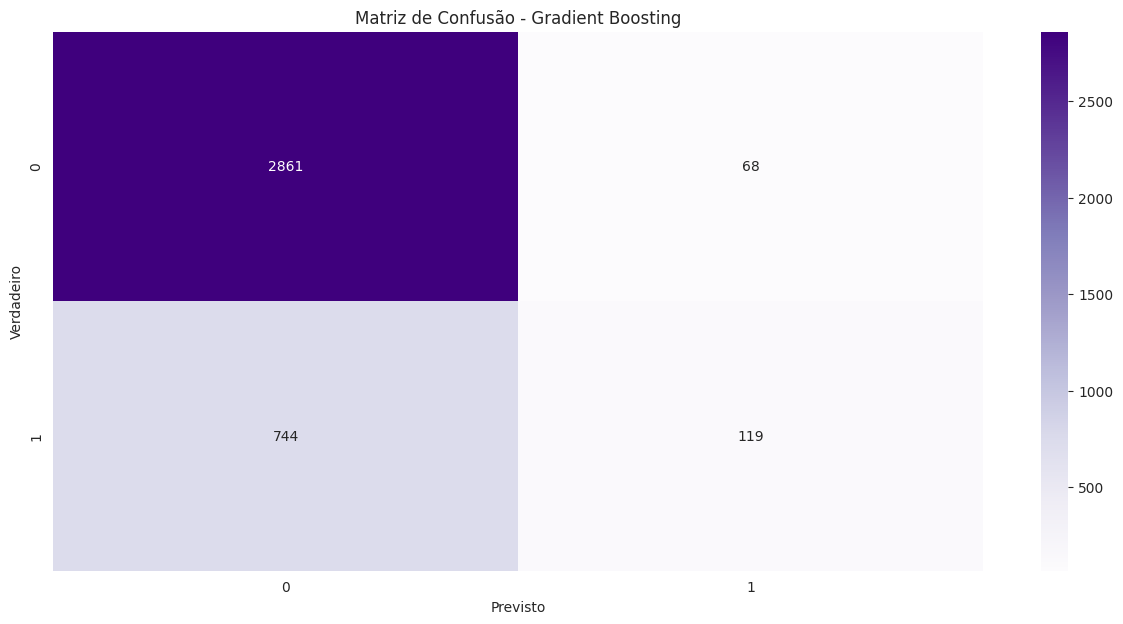

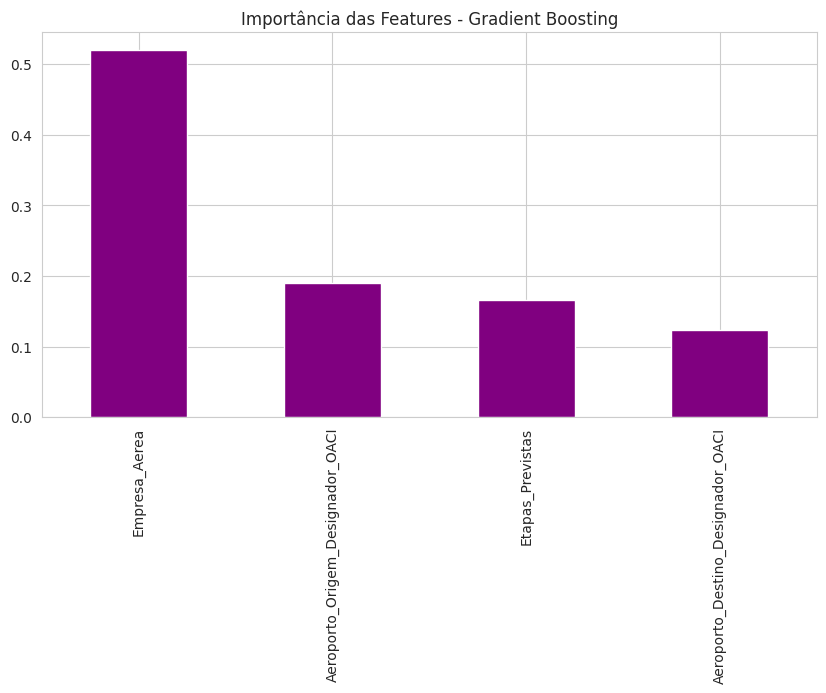

In [11]:
if 'X_train' in locals() and 'y_train' in locals(): # Verifica se X_train e y_train foram definidos
    # Modelo 3: Random Forest
    print("") # Adiciona uma linha em branco antes do título
    print("--- Treinando Random Forest ---")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=5, class_weight='balanced') # Parâmetros para evitar overfitting e lidar com desbalanceamento
    rf_clf.fit(X_train, y_train)
    y_pred_rf = rf_clf.predict(X_test)
    
    print("Acurácia do Random Forest:", accuracy_score(y_test, y_pred_rf))
    print("Relatório de Classificação do Random Forest:")
    print(classification_report(y_test, y_pred_rf, zero_division=0))
    print("Matriz de Confusão do Random Forest:")
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Oranges")
    plt.title("Matriz de Confusão - Random Forest")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.show()

    if hasattr(rf_clf, "feature_importances_") and X_train.shape[1] > 0:
        importances_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        importances_rf.plot(kind="bar", color='orange')
        plt.title("Importância das Features - Random Forest")
        plt.show()

    # Modelo 4: Gradient Boosting
    print("") # Adiciona uma linha em branco antes do título
    print("--- Treinando Gradient Boosting ---")
    gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=3, learning_rate=0.1)
    gb_clf.fit(X_train, y_train)
    y_pred_gb = gb_clf.predict(X_test)
    
    print("Acurácia do Gradient Boosting:", accuracy_score(y_test, y_pred_gb))
    print("Relatório de Classificação do Gradient Boosting:")
    print(classification_report(y_test, y_pred_gb, zero_division=0))
    print("Matriz de Confusão do Gradient Boosting:")
    sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt="d", cmap="Purples")
    plt.title("Matriz de Confusão - Gradient Boosting")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.show()

    if hasattr(gb_clf, "feature_importances_") and X_train.shape[1] > 0:
        importances_gb = pd.Series(gb_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        importances_gb.plot(kind="bar", color='purple')
        plt.title("Importância das Features - Gradient Boosting")
        plt.show()
else:
    print("Dados de treino (X_train, y_train) não foram preparados ou estão vazios. Modelos de Ensemble não podem ser treinados.")

## 6. Conclusões Preliminares

Esta seção resumiria os achados da análise exploratória e da modelagem. Dado o foco em simplicidade, os modelos apresentados são básicos e servem como ponto de partida. A performance pode ser melhorada com engenharia de features mais elaborada, seleção de modelos mais complexos e otimização de hiperparâmetros. No entanto, para o escopo deste projeto, demonstramos o fluxo de análise de dados e aplicação de machine learning para o problema de atrasos em voos.